# Field Validation

In [ ]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.preprocessing import *
from utils.segmentation import *


In [4]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
df.drop(columns=['Unnamed: 0'], inplace=True) 
df.head()

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [5]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape



((2443, 100), (243, 100))

In [6]:
# Make predictions using autoencoder
autoencoder = tf.keras.models.load_model('../../models/autoencoder_best.keras')
with open('../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\liuzi\AppData\Local\Temp\ipykernel_15984\2162391532.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


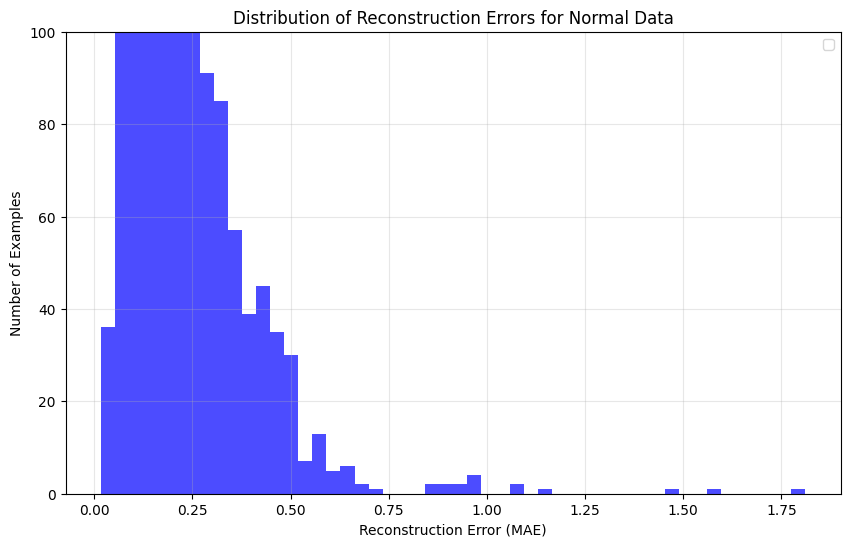

In [7]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = autoencoder.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal, bins=50, color='blue', alpha=0.7)

plt.title('Distribution of Reconstruction Errors for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


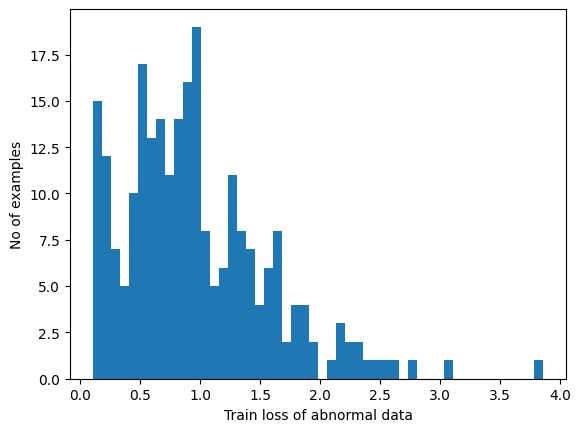

In [8]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = autoencoder.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal[None,:], bins=50)
plt.xlabel("Train loss of abnormal data")
plt.ylabel("No of examples")
plt.show()

In [9]:
# Find indices where reconstruction error is less than 0.5
low_reconstruction_indices = np.where(train_loss_abnormal < 0.4)[0]

# Get the indices of abnormal samples in the original dataframe
abnormal_mask = df['curb_scene'] == 1
abnormal_indices = df[abnormal_mask].index

# Map the indices from abnormal subset to original dataframe indices
original_indices = abnormal_indices[low_reconstruction_indices]

print("\nCorresponding indices in original dataframe:")
print(original_indices)



Corresponding indices in original dataframe:
Index([ 280,  520,  521,  687,  888,  889,  891, 1164, 1172, 1270, 1271, 1272,
       1356, 1415, 1492, 1493, 1494, 1635, 1931, 2214, 2224, 2301, 2391, 2392,
       2397, 2399, 2410, 2417, 2419, 2420, 2427, 2429, 2464, 2473, 2481, 2491,
       2494, 2496, 2506],
      dtype='int64')


In [10]:
# Add the loss values back to the original DataFrame
df.loc[df['curb_scene'] == 0, 'loss'] = train_loss_normal.numpy()
df.loc[df['curb_scene'] == 1, 'loss'] = train_loss_abnormal.numpy()

In [14]:
indices = [130,131,132,133]
df.iloc[indices, df.columns.get_loc('curb_scene')] = 0

In [32]:
df.iloc[2527, df.columns.get_loc('curb_scene')] = 1

In [15]:
# Alternatively, for better notebook display:
df_selected = df[['curb_scene', 'start_time', 'loss']]
df_selected.iloc[131-5:131+10]

,curb_scene,start_time,loss
126,0,2025-03-28 16:01:50.376,0.113790
127,0,2025-03-28 16:01:50.873,0.127453
128,0,2025-03-28 16:01:51.369,0.150032
129,0,2025-03-28 16:01:51.867,0.197919
130,0,2025-03-28 16:01:52.402,0.537489
131,0,2025-03-28 16:01:52.898,0.420611
132,0,2025-03-28 16:01:53.395,0.425225
133,0,2025-03-28 16:01:53.891,0.564024
134,0,2025-03-28 16:01:54.363,0.404974
135,0,2025-03-28 16:01:54.860,0.228412


In [88]:
df.drop(columns=['loss'], inplace=True)

In [89]:
df.head()

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [16]:
df.drop(columns=['loss'], inplace=True)
df.to_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_changed.csv', index=False)